# SNN Testing & Short-Term Plasticity (STP) Evaluation
This notebook evaluates a pre-trained Spiking Neural Network (SNN) on EEG seizure detection, then applies **Short-Term Plasticity (STP)** to improve classification via adaptive thresholding. The pipeline: load data → encode spikes → run inference → compute STP parameters → compare performance.

## 1. Environment Setup & Imports
Detect runtime (Colab vs local), install dependencies, and clone the model repository.

In [1]:
try:
  import google.colab
  print('colab env')
  !pip install snntorch
  !pip install mne
except:
  print('local env')
  pass

import sys
import snntorch as snn
import gdown
import pickle
import numpy as np
# Import dataloader utilities
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import snntorch as snn
import os
from collections import deque

!git clone https://github.com/andem25/STPSNN

colab env
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 62.1 MB/s eta 0:00:0000:0100:01
Cloning into 'STPSNN'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 33 (delta 10), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (33/33), 24.21 KiB | 669.00 KiB/s, done.
Resolving deltas: 100% (10/10), done.


## 2. Download Dataset
Download the EEG dataset from Google Drive (skipped if already present).

In [2]:
# Skip download if data folder already exists
if os.path.exists("data"):
    print("Dataset already present")
else:
    gdown.download_folder('https://drive.google.com/drive/folders/1EARnrSSj1DeHf0OiBmQ6_wcCJjKc8a2m?usp=sharing', output='data', quiet=False, use_cookies=False)

Retrieving folder contents


Retrieving folder 1rqJOjZOzsWK4drpbKYTuE7ABfKCnuOPo test_routine
Retrieving folder 1SRDDpnTHSIniATUZcazrksQllmpCwZvg test
Processing file 1jgClrq9tjc7iKXaKZuYMJh3XxcFyVi29 label_window.pkl
Processing file 1Zsag47aWaX75D9cx76gls3LodLlYpy-t training_window.pkl
Retrieving folder 1WuCyBRqA5bB9nueVyXrEvbVC9qxjaKwd train
Processing file 1gQ8bRP44e-2RBpnQUKpM0G50Qkf6b-Rx label_window.pkl
Processing file 10cFynxBhfgm_C9ju2pV0z9k9DOeXFep_ training_window.pkl
Retrieving folder 1y2a4DdWYtLUsTqJQUOGUwPwFlSmEVwKF train_routine
Processing file 1MVLMfwhbt9z5cEvX50pn9N6TCjyl3o_A train_data.pkl
Processing file 1Ub2DxBv0RMj6NKXLL_dxqc3MGtgCL4qG valid_data.pkl
Processing file 1_stWbLVvYo6Sm7ERKKc4M9Imh289A3Rd y_train.pkl
Processing file 1s1x_jHFLTIJ47BKHvLztJ7Ayps_UN2LQ y_valid.pkl


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1jgClrq9tjc7iKXaKZuYMJh3XxcFyVi29
To: /content/data/test_routine/test/label_window.pkl
100%|██████████| 17.0k/17.0k [00:00<00:00, 22.5MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1Zsag47aWaX75D9cx76gls3LodLlYpy-t
From (redirected): https://drive.google.com/uc?id=1Zsag47aWaX75D9cx76gls3LodLlYpy-t&confirm=t&uuid=cb87f4d2-6c1c-45e4-88d6-c8dbd5f9f2a9
To: /content/data/test_routine/test/training_window.pkl
100%|██████████| 137M/137M [00:01<00:00, 69.8MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1gQ8bRP44e-2RBpnQUKpM0G50Qkf6b-Rx
To: /content/data/test_routine/train/label_window.pkl
100%|██████████| 25.6k/25.6k [00:00<00:00, 33.6MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=10cFynxBhfgm_C9ju2pV0z9k9DOeXFep_
From (redirected): https://drive.google.com/uc?id=10cFynxBhfgm_C9ju2pV0z

## 3. Load Preprocessed Data
Load train/test windowed EEG data and labels from pickle files.

In [3]:
# open pickle file
with open('data/test_routine/train/training_window.pkl', 'rb') as f:
    train_training = pickle.load(f)

with open('data/test_routine/train/label_window.pkl', 'rb') as f:
    train_label = pickle.load(f)

with open('data/test_routine/test/training_window.pkl', 'rb') as f:
    test_test = pickle.load(f)

with open('data/test_routine/test/label_window.pkl', 'rb') as f:
    test_label = pickle.load(f)
    

## 4. Load Training Config & Normalization Bounds
Read the saved training results (min/max values used for spike encoding normalization).

In [10]:
import json


FOLDER_OUT = 'trained_folder'

with open('./STPSNN/%s/training_results.json' % FOLDER_OUT, 'r') as f:
    results = json.load(f)

max_train = results['massimo']
min_train = results['minimo']

print(f"Maximum: {max_train}")
print(f"Minimum: {min_train}")



Maximum: [285.8119658119658, 223.2967032967033, 269.4017094017094, 164.6886446886447]
Minimum: [-285.8119658119658, -223.2967032967033, -269.4017094017094, -164.6886446886447]


## 5. Spike Encoding
Encode raw EEG windows into spike trains using min/max normalization from training.

In [11]:
from STPSNN.encoding_functions import encode, EEG_Dataset
train_spk_list = []
test_spk_list = []



for win in train_training:
    spk = encode(np.swapaxes(np.squeeze(win), 1, 2), max_train, min_train)
    train_spk_list.append(spk)

train_spk = np.concatenate(train_spk_list, axis=0)
print("Train spikes shape:", train_spk.shape)


for win in test_test:
    spk = encode(np.swapaxes(np.squeeze(win), 1, 2), max_train, min_train)
    test_spk_list.append(spk)

test_spk = np.concatenate(test_spk_list, axis=0)

print("Test spikes shape:", test_spk.shape)

massimo [285.8119658119658, 223.2967032967033, 269.4017094017094, 164.6886446886447]
minimo [-285.8119658119658, -223.2967032967033, -269.4017094017094, -164.6886446886447]
massimo [285.8119658119658, 223.2967032967033, 269.4017094017094, 164.6886446886447]
minimo [-285.8119658119658, -223.2967032967033, -269.4017094017094, -164.6886446886447]
massimo [285.8119658119658, 223.2967032967033, 269.4017094017094, 164.6886446886447]
minimo [-285.8119658119658, -223.2967032967033, -269.4017094017094, -164.6886446886447]
massimo [285.8119658119658, 223.2967032967033, 269.4017094017094, 164.6886446886447]
minimo [-285.8119658119658, -223.2967032967033, -269.4017094017094, -164.6886446886447]
massimo [285.8119658119658, 223.2967032967033, 269.4017094017094, 164.6886446886447]
minimo [-285.8119658119658, -223.2967032967033, -269.4017094017094, -164.6886446886447]
massimo [285.8119658119658, 223.2967032967033, 269.4017094017094, 164.6886446886447]
minimo [-285.8119658119658, -223.2967032967033, -2

## 6. Network Initialization & DataLoaders
Reshape spike data, create DataLoaders, and load the pre-trained SNN weights (STP disabled).

In [12]:
from STPSNN.net_definition import Net



num_inputs = train_spk.shape[1] * train_spk.shape[3]
b_train = train_spk.transpose(1, 0, 2, 3).reshape(1, 4, train_spk.shape[0]*train_spk.shape[2], 16)
num_steps_train = b_train.shape[2]
print(f"train_spk shape: {train_spk.shape}")
print(f"num_steps_train: {num_steps_train}")


train_dataset = EEG_Dataset(b_train, np.zeros(1))
batch_size = 1 # Batch size
train_dataloader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)


num_inputs = test_spk.shape[1] * test_spk.shape[3]
b_test = test_spk.transpose(1, 0, 2, 3).reshape(1, 4, test_spk.shape[0]*test_spk.shape[2], 16)
num_steps_test = b_test.shape[2]
print(f"test_spk shape: {test_spk.shape}")
print(f"num_steps_test: {num_steps_test}")



test_dataset = EEG_Dataset(b_test, np.zeros(1))
batch_size = 1 # Batch size
test_dataloader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

num_outputs = 1

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Network for TRAIN set (STP disabled)
net = Net(num_inputs, num_outputs, num_steps_train, STP_enable = False).to(device)
net.load_state_dict(torch.load('./STPSNN/%s/network.pt' % FOLDER_OUT))
print("Network loaded successfully.")
print(f"\nnet initialized with num_steps_train={num_steps_train}")

train_spk shape: (3150, 4, 2048, 16)
num_steps_train: 6451200
test_spk shape: (2090, 4, 2048, 16)
num_steps_test: 4280320
Network loaded successfully.

net initialized with num_steps_train=6451200


## 7. Label Preparation
Expand per-window labels to per-timestep labels (2048 timesteps per window) for both train and test sets.

In [13]:
def return_rates_fast(arr, size=1024):
    arr = np.array(arr)
    # print(arr.shape)
    first = sum(arr[:size])
    rates = []
    for i in range(len(arr)):
        if i<size:
            rates.append(sum(arr[:i]))
        else:
            rates.append(first)
            first = first - arr[i-size] + arr[i]
    return np.array(rates)


# TRAIN labels (already filtered to [0:2] above)
y_in_train = np.concatenate(train_label)
y_intrain = []
for i in range(len(y_in_train)):
  for ind in range(2048):
    y_intrain.append(y_in_train[i])
y_intrain = np.array(y_intrain)
y_intrain = y_intrain[0:len(train_spk)*train_spk.shape[2]]
print(f"y_intrain length: {len(y_intrain)}, train timesteps: {len(train_spk)*train_spk.shape[2]}")

# TEST labels (already filtered to [-2:] above)
y_in_test = np.concatenate(test_label)
y_intest = []
for i in range(len(y_in_test)):
    for ind in range(2048):
        y_intest.append(y_in_test[i])
y_intest = np.array(y_intest)
y_intest = y_intest[0:len(test_spk)*test_spk.shape[2]]
print(f"y_intest length: {len(y_intest)}, test timesteps: {len(test_spk)*test_spk.shape[2]}")



y_intrain length: 6451200, train timesteps: 6451200
y_intest length: 4280320, test timesteps: 4280320


## 8. Inference on Training Set
Run the network on training data to extract output firing rates and hidden layer spikes (needed for STP calibration).

In [17]:
from STPSNN.test_routine import test
eval_ratesfr, spk_1_recfr = test(net, train_dataloader, num_steps_train, device)


## 9. Output Rate Visualization (Train)
Plot the output neuron firing rate over time with seizure intervals highlighted.

start: 1687552, end: 1699839
start: 2217984, end: 2226175
start: 3207168, end: 3219455
start: 3946496, end: 3958783
start: 5048320, end: 5070847
start: 5613568, end: 5638143


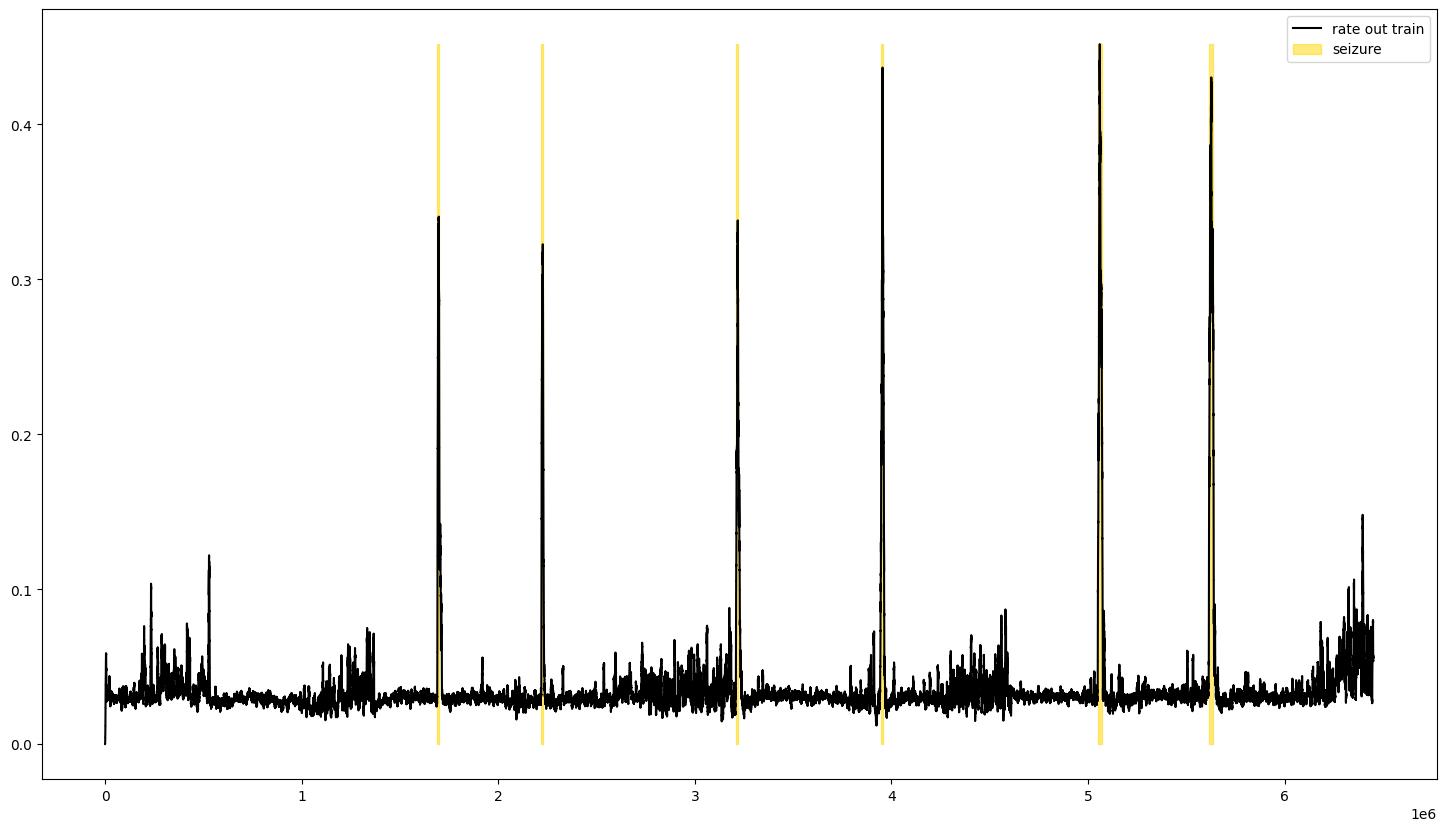

In [18]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
start = np.where(np.diff(np.concatenate(([0], y_intrain, [0]))) == 1)[0]
end = np.where(np.diff(np.concatenate(([0], y_intrain, [0]))) == -1)[0] - 1


rates = return_rates_fast(np.array(eval_ratesfr).flatten(), 4096)/4096
plt.figure(figsize=(18, 10))
plt.plot(rates, color = "black", label="rate out train")
for i in range(len(start)):
  print(f"start: {start[i]}, end: {end[i]}")
  plt.fill_between([start[i], end[i]], min(rates), max(rates), color='gold', alpha=0.5, label="seizure" if i == 0 else "")
plt.legend()
plt.show()

## 10. Hidden Layer Firing Rate Analysis
Compute per-neuron firing rates during non-seizure (baseline) and seizure periods. These statistics drive the STP potentiation/depression parameters.

In [19]:
import matplotlib.pyplot as plt
import statistics as st

var = np.array(spk_1_recfr)
var = var.squeeze()
var = var.transpose()
var.shape

frout = []
frs = []

rate_out = return_rates_fast(eval_ratesfr.flatten(), 4096)/4096
index_w_less_5 = []
for i in range(len(rate_out)):
  if rate_out[i] < 0.05 and i >= 4096 and y_intrain[i] == 0:
    index_w_less_5.append(i)

index_w_less_5 = np.array(index_w_less_5)

weights  = net.fc2.weight.detach().tolist()[0]
weights = np.array(weights)

for elem, w in zip(var, weights):
  rates = return_rates_fast(np.array(elem).flatten(), 4096)/4096
  frout.append(float(np.average(rates[index_w_less_5])))
  frs.append(float(np.average(rates[y_intrain==1])))
  plt.show()

print("Frout")
print(frout)
print("Frs")
print(frs)



Frout
[0.10716607857884668, 0.2523043223691943, 0.31186571288764275, 0.22485205847666512, 0.26668091346769657, 0.29738041813073873, 0.1524286351376489, 0.3897985722015093]
Frs
[0.16928697162204318, 0.42834743128882513, 0.49546723100874157, 0.24505714310540094, 0.22137745751274956, 0.4728294266594781, 0.364676472875807, 0.5454196638531155]


## 11. STP Parameter Computation
Derive potentiation and depression rates from baseline firing rates and network weights.

In [20]:
# fr = scripts.np.array(fravg)
fr = np.array(frout)
# fr = scripts.np.array(frmode)
pot = [0.00001 for i in range(len(fr))]
pot = np.array(pot)
dep = ((1-fr)*pot/fr)/32
pot = pot/32

pesi = net.fc2.weight.detach().tolist()[0]

print("Weights")
print(pesi)
print("Frout")
print(fr)
print("Potentiation")
print(pot)
print("Depression")
print(dep)
print("Frs")
print(frs)

Weights
[-0.7355971336364746, 0.3522675633430481, 0.32229164242744446, -0.691787838935852, -0.6197860836982727, 0.1873110830783844, 0.24504368007183075, 0.3422446548938751]
Frout
[0.10716608 0.25230432 0.31186571 0.22485206 0.26668091 0.29738042
 0.15242864 0.38979857]
Potentiation
[3.125e-07 3.125e-07 3.125e-07 3.125e-07 3.125e-07 3.125e-07 3.125e-07
 3.125e-07]
Depression
[2.60353466e-06 9.26083616e-07 6.89533847e-07 1.07730271e-06
 8.59312395e-07 7.38342560e-07 1.73763972e-06 4.89196113e-07]
Frs
[0.16928697162204318, 0.42834743128882513, 0.49546723100874157, 0.24505714310540094, 0.22137745751274956, 0.4728294266594781, 0.364676472875807, 0.5454196638531155]


## 12. Output Rate Distribution Analysis
Bin the output firing rate into 32 levels and compare distributions between seizure vs non-seizure periods. The mode/median levels set the **deactivation rate** (adaptive threshold baseline).

(92160, 32)


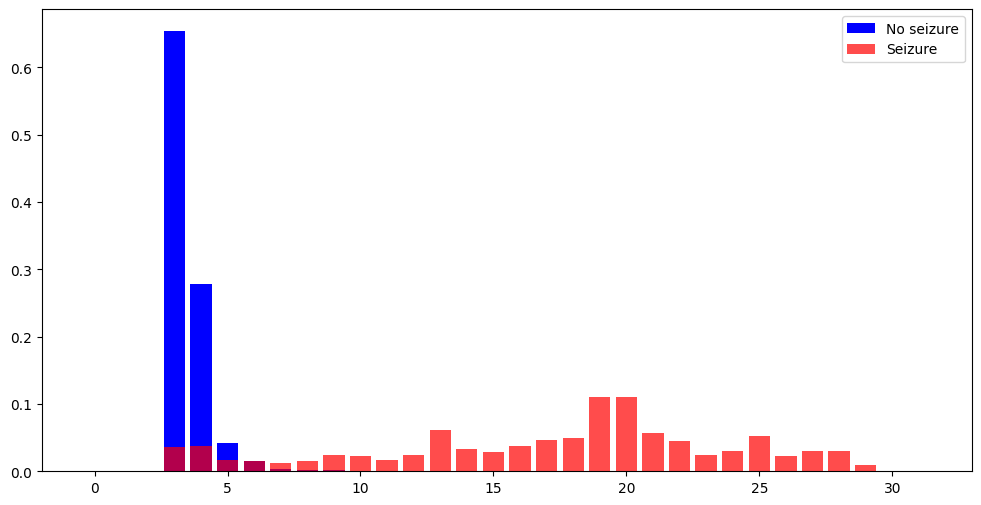

Seizure mode level: 20, Average value: 0.1111
Upper bound of interval (mode): 0.306484

Median level: 15, Average value: 0.0293
Upper bound of interval (median): 0.225830


In [21]:
# plt.plot(rates_train)
no_seiz_list = []
seiz_list = []

rates = return_rates_fast(np.array(eval_ratesfr).flatten(), 4096)/4096

def level_define_16(val, massimo, minimo):
    lunghezza = massimo - minimo
    step = lunghezza / 28
    base = minimo - 2*step
    
    encoded = []
    for i in range(1,33):
        if i == 32:
            if val>(base+(i-1)*step):
                encoded.append(1)
        else:
            if val<(base+i*step):
                encoded.append(1)
                break
            else:
                encoded.append(0)
    for k in range(32-len(encoded)):
        encoded.append(0)
    return encoded


maxr = max(rates)
minr = min(rates)

for val, seiz in zip(rates, y_intrain):
    if seiz:
        seiz_list.append(level_define_16(val, maxr, minr))
    else:
        no_seiz_list.append(level_define_16(val, maxr, minr))

seiz_list = np.array(seiz_list)
no_seiz_list = np.array(no_seiz_list)


print(seiz_list.shape)
mean_no_seiz = np.mean(no_seiz_list, axis=0)
mean_seiz = np.mean(seiz_list, axis=0)


plt.figure(figsize=(12, 6), dpi=100)
plt.bar(range(32), mean_no_seiz, label='No seizure', color='b')
plt.bar(range(32), mean_seiz, label='Seizure', color='r', alpha=0.7)
plt.legend()
plt.show()

# Find the level (index) with maximum value (mode) and median
livello_moda = np.argmax(mean_seiz)  # Index of maximum value
livello_mediana = int(np.median(np.arange(32)))  # Median level (central index)

# Compute the upper bound of the interval for the found level
lunghezza = maxr - minr
step = lunghezza / 28
base = minr - 2*step

# Upper bound for the level (1-indexed, so level+1)
estremo_sup_moda = base + (livello_moda + 1) * step
estremo_sup_mediana = base + (livello_mediana + 1) * step

print(f"Seizure mode level: {livello_moda}, Average value: {mean_seiz[livello_moda]:.4f}")
print(f"Upper bound of interval (mode): {estremo_sup_moda:.6f}")
print(f"\nMedian level: {livello_mediana}, Average value: {mean_seiz[livello_mediana]:.4f}")
print(f"Upper bound of interval (median): {estremo_sup_mediana:.6f}")

## 13. Baseline Test (No STP)
Run the network on the test set **without STP** to establish baseline performance.

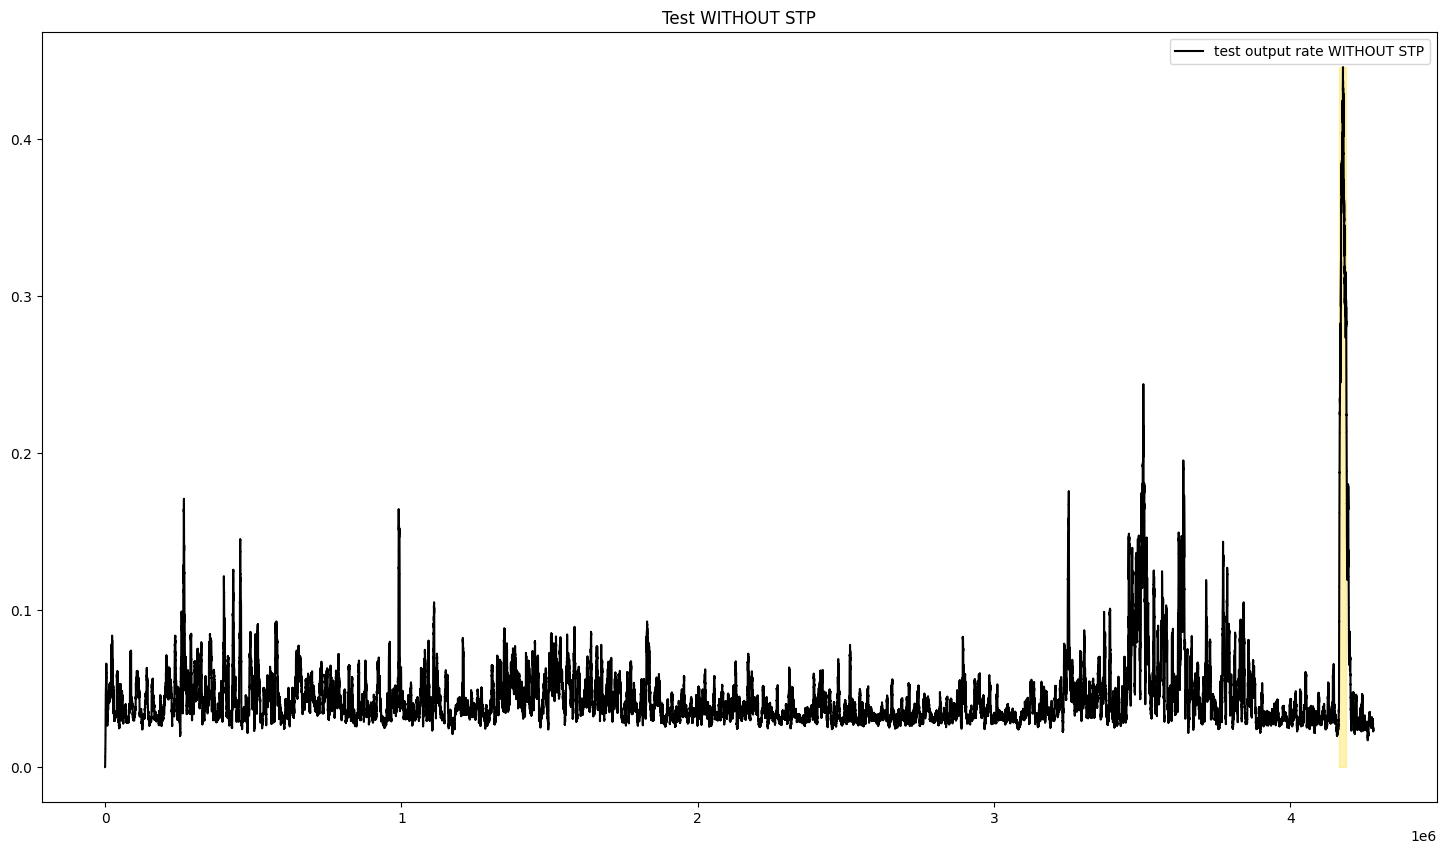

In [22]:
# Recreate network with num_steps_test for the test set
net_test = Net(num_inputs, num_outputs, num_steps_test, STP_enable = False).to(device)
net_test.load_state_dict(torch.load('./STPSNN/%s/network.pt' % FOLDER_OUT))

# Test without STP on test set (baseline for comparison)
eval_rates_no_stp, spk_1_rec_no_stp = test(net_test, test_dataloader, num_steps_test, device)

# Compute firing rate without STP on test set
start_test = np.where(np.diff(np.concatenate(([0], y_intest, [0]))) == 1)[0]
end_test = np.where(np.diff(np.concatenate(([0], y_intest, [0]))) == -1)[0] - 1

rates_no_stp = return_rates_fast(np.array(eval_rates_no_stp).flatten(), 4096)/4096
plt.figure(figsize=(18, 10))
plt.plot(rates_no_stp, color="black", label="test output rate WITHOUT STP")
plt.legend()
plt.title("Test WITHOUT STP")
for i in range(len(start_test)):

    plt.fill_between([start_test[i], end_test[i]], min(rates_no_stp), max(rates_no_stp), color='gold', alpha=0.3, label="seizure" if i == 0 else "")
    plt.show()

## 14. STP-Enabled Network Setup
Initialize a new network instance with STP enabled, using the computed potentiation/depression rates and deactivation threshold.

In [23]:
print(pot)
print(dep)

[3.125e-07 3.125e-07 3.125e-07 3.125e-07 3.125e-07 3.125e-07 3.125e-07
 3.125e-07]
[2.60353466e-06 9.26083616e-07 6.89533847e-07 1.07730271e-06
 8.59312395e-07 7.38342560e-07 1.73763972e-06 4.89196113e-07]


In [24]:
# Initialize network WITH STP enabled
weight_start = net.fc2.weight.detach().clone()
STP_pot = pot
STP_dep = dep
deactivation_rate = min([estremo_sup_moda, estremo_sup_mediana])  # Deactivation rate based on mode and median levels
print(f"Deactivation rate set to: {deactivation_rate:.6f}")


net_stp = Net(
    num_inputs=num_inputs, 
    num_outputs=num_outputs, 
    num_steps=num_steps_test, 
    STP_enable=True,
    weight_start=weight_start,
    STP_pot=STP_pot,
    STP_dep=STP_dep,
    fr=fr,
    fr_seiz=np.array(frs),
    deactivation_rate=deactivation_rate
).to(device)

net_stp.load_state_dict(torch.load('./STPSNN/%s/network.pt' % FOLDER_OUT))
print("Network WITH STP loaded successfully.")

Deactivation rate set to: 0.225830
minimo_pesi [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]
Network WITH STP loaded successfully.


## 15. Inference with STP
Run the STP-enabled network on the test set.

In [25]:

# Test network WITH STP on test set
eval_rates_stp, spk_1_rec_stp = test(net_stp, test_dataloader, num_steps_test, device)

## 16. STP vs No-STP Comparison
Visual comparison of output firing rates on the test set: baseline (static threshold) vs STP (adaptive threshold).

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


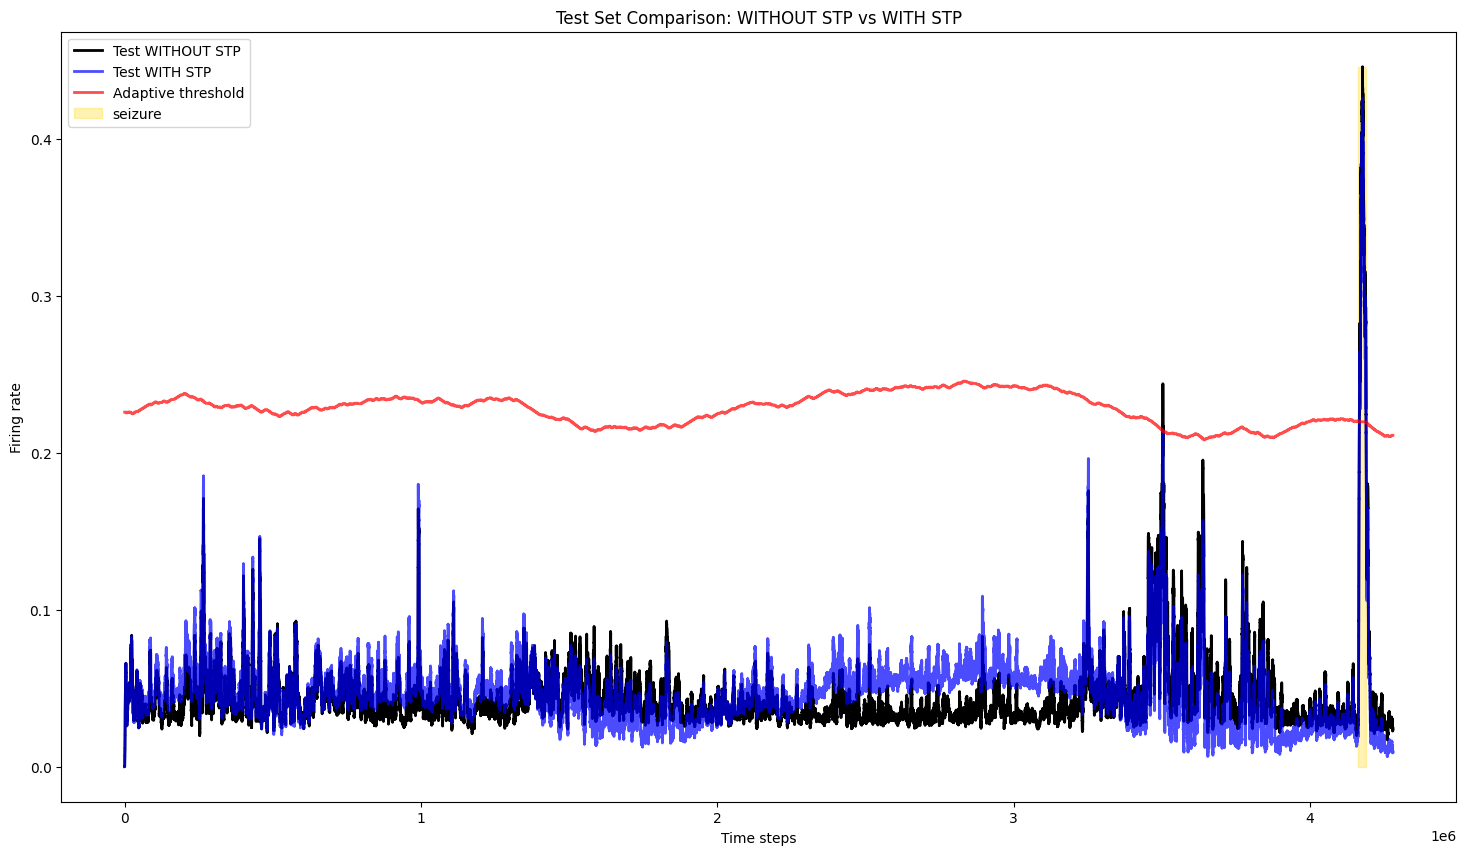

In [26]:
# Visual comparison: No STP vs STP on TEST set
rates_stp = return_rates_fast(np.array(eval_rates_stp).flatten(), 4096)/4096
plt.figure(figsize=(18, 10))
plt.plot(rates_no_stp, color="black", label="Test WITHOUT STP", linewidth=2)
plt.plot(rates_stp, color="blue", label="Test WITH STP", linewidth=2, alpha=0.7)
plt.plot(net_stp.threc, color="red", label="Adaptive threshold", linewidth=2, alpha=0.7)
for i in range(len(start_test)):
    plt.fill_between([start_test[i], end_test[i]], min(rates_stp.tolist() + rates_no_stp.tolist()), max(rates_stp.tolist() + rates_no_stp.tolist()), color='gold', alpha=0.3, label="seizure" if i == 0 else "")
plt.legend()
plt.title("Test Set Comparison: WITHOUT STP vs WITH STP")
plt.xlabel("Time steps")
plt.ylabel("Firing rate")
plt.show()

## 17. Classification Metrics & Confusion Matrices
Evaluate both models with **20s pre-ictal tolerance** (ignore predictions 20s before seizure start) and **15-min post-ictal suppression** (ignore predictions right after a seizure ends). Compare accuracy, sensitivity, specificity, and precision.

Total suppressed timesteps: 97280 out of 4280320 total
Seizures detected: 1
Pre-ictal tolerance: 20s (5120 timesteps) before each seizure
Post-ictal suppression: 15 min (230400 timesteps) after each seizure


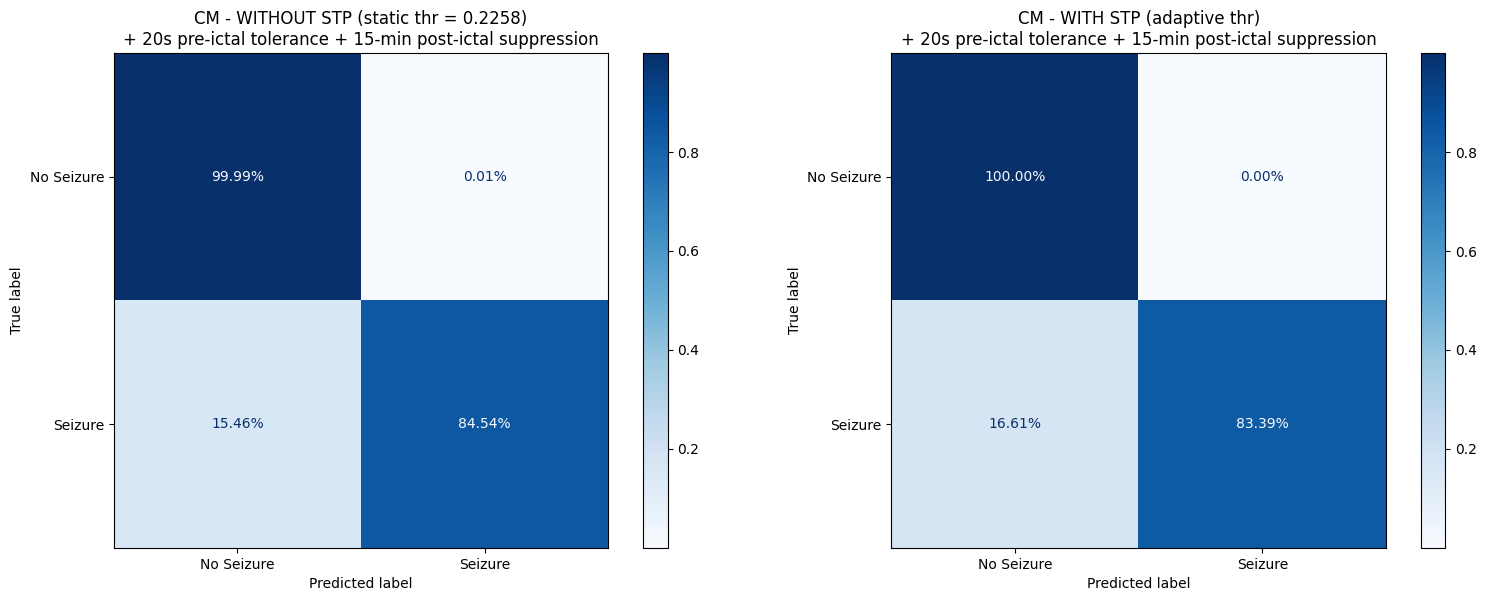

PERFORMANCE COMPARISON (with 20s pre-ictal tolerance + 15-min post-ictal suppression)

WITHOUT STP (static threshold):
  Accuracy:    0.9990
  Sensitivity: 0.8454
  Specificity: 0.9999
  Precision:   0.9780

WITH STP (adaptive threshold):
  Accuracy:    0.9990
  Sensitivity: 0.8339
  Specificity: 1.0000
  Precision:   0.9997

IMPROVEMENT (WITH STP - WITHOUT STP):
  Accuracy:    +0.0000
  Sensitivity: -0.0115
  Specificity: +0.0001
  Precision:   +0.0216


In [27]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Ground truth labels
y_true = y_intest

# --- Pre-ictal and Post-ictal suppression ---
# Pre-ictal tolerance: 20 seconds before seizure start
# Post-ictal suppression: 15 minutes after seizure end
# Each window = 8s, 2048 timesteps -> 256 Hz effective sampling rate
PREICTAL_TOLERANCE = 20 * 256  # 20 seconds = 5120 timesteps
POSTICTAL_SUPPRESS = 15 * 60 * 256  # 15 minutes = 230400 timesteps

# Find seizure start and end indices in ground truth labels
start_seizure_test = np.where(np.diff(np.concatenate(([0], y_true, [0]))) == 1)[0]
end_seizure_test = np.where(np.diff(np.concatenate(([0], y_true, [0]))) == -1)[0] - 1

# Suppression mask: True where predictions should be zeroed out
suppress_mask = np.zeros(len(y_true), dtype=bool)

# Apply pre-ictal tolerance (20s before each seizure start)
for s in start_seizure_test:
    pre_start = max(0, s - PREICTAL_TOLERANCE)
    pre_end = s
    suppress_mask[pre_start:pre_end] = True

# Apply post-ictal suppression (15 min after each seizure end)
for e in end_seizure_test:
    post_start = e + 1
    post_end = min(e + 1 + POSTICTAL_SUPPRESS, len(y_true))
    suppress_mask[post_start:post_end] = True

print(f"Total suppressed timesteps: {suppress_mask.sum()} out of {len(y_true)} total")
print(f"Seizures detected: {len(start_seizure_test)}")
print(f"Pre-ictal tolerance: 20s ({PREICTAL_TOLERANCE} timesteps) before each seizure")
print(f"Post-ictal suppression: 15 min ({POSTICTAL_SUPPRESS} timesteps) after each seizure")

# CASE 1: Without STP, static threshold
static_threshold = deactivation_rate
y_pred_no_stp = (rates_no_stp > static_threshold).astype(int)
y_pred_no_stp_suppressed = y_pred_no_stp.copy()
y_pred_no_stp_suppressed[suppress_mask] = 0

# CASE 2: With STP, adaptive threshold
y_pred_stp = (rates_stp > np.array(net_stp.threc)).astype(int)
y_pred_stp_suppressed = y_pred_stp.copy()
y_pred_stp_suppressed[suppress_mask] = 0

# --- Confusion matrices with pre-ictal tolerance and post-ictal suppression ---
cm_no_stp = confusion_matrix(y_true, y_pred_no_stp_suppressed, normalize='true')
cm_stp = confusion_matrix(y_true, y_pred_stp_suppressed, normalize='true')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_no_stp, display_labels=['No Seizure', 'Seizure'])
disp1.plot(cmap='Blues', ax=ax1, values_format='.2%')
ax1.set_title(f'CM - WITHOUT STP (static thr = {static_threshold:.4f})\n+ 20s pre-ictal tolerance + 15-min post-ictal suppression')

disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_stp, display_labels=['No Seizure', 'Seizure'])
disp2.plot(cmap='Blues', ax=ax2, values_format='.2%')
ax2.set_title('CM - WITH STP (adaptive thr)\n+ 20s pre-ictal tolerance + 15-min post-ictal suppression')

plt.tight_layout()
plt.show()

# Metrics comparison
print("=" * 70)
print("PERFORMANCE COMPARISON (with 20s pre-ictal tolerance + 15-min post-ictal suppression)")
print("=" * 70)

# Metrics without STP
cm_no_stp_abs = confusion_matrix(y_true, y_pred_no_stp_suppressed)
tn1, fp1, fn1, tp1 = cm_no_stp_abs.ravel()
acc1 = (tp1 + tn1) / (tp1 + tn1 + fp1 + fn1)
sens1 = tp1 / (tp1 + fn1) if (tp1 + fn1) > 0 else 0
spec1 = tn1 / (tn1 + fp1) if (tn1 + fp1) > 0 else 0
prec1 = tp1 / (tp1 + fp1) if (tp1 + fp1) > 0 else 0

# Metrics with STP
cm_stp_abs = confusion_matrix(y_true, y_pred_stp_suppressed)
tn2, fp2, fn2, tp2 = cm_stp_abs.ravel()
acc2 = (tp2 + tn2) / (tp2 + tn2 + fp2 + fn2)
sens2 = tp2 / (tp2 + fn2) if (tp2 + fn2) > 0 else 0
spec2 = tn2 / (tn2 + fp2) if (tn2 + fp2) > 0 else 0
prec2 = tp2 / (tp2 + fp2) if (tp2 + fp2) > 0 else 0

print("\nWITHOUT STP (static threshold):")
print(f"  Accuracy:    {acc1:.4f}")
print(f"  Sensitivity: {sens1:.4f}")
print(f"  Specificity: {spec1:.4f}")
print(f"  Precision:   {prec1:.4f}")

print("\nWITH STP (adaptive threshold):")
print(f"  Accuracy:    {acc2:.4f}")
print(f"  Sensitivity: {sens2:.4f}")
print(f"  Specificity: {spec2:.4f}")
print(f"  Precision:   {prec2:.4f}")

print("\nIMPROVEMENT (WITH STP - WITHOUT STP):")
print(f"  Accuracy:    {acc2-acc1:+.4f}")
print(f"  Sensitivity: {sens2-sens1:+.4f}")
print(f"  Specificity: {spec2-spec1:+.4f}")
print(f"  Precision:   {prec2-prec1:+.4f}")
print("=" * 70)